In [1]:
import numpy as np
import gvar as gv
import sys
sys.path.append('../')
from h5glance import H5Glance 
import h5py 
import os
import lsqfit
import io
import yaml
import matplotlib
import matplotlib.pyplot as plt
import warnings  
warnings.simplefilter(action="default")
#import plotly.io as pio
#renderers.default = 'iframe_connected'

warnings.filterwarnings('ignore') 

In [2]:
os.chdir('../../nucleon_sigma/xpt')

In [3]:
import fit_analysis as fa 
import fit_routine as fit
import i_o
import priors
import fpi_fit
import mpi_fit
import plots

In [4]:
from priors import prior
prior = prior


In [5]:
gv.load('../data/a_fm_results.p')

BufferDict([('a15', 0.15036(98)), ('a12', 0.12055(83)), ('a09', 0.08722(67)), ('a06', 0.05686(49))])

In [6]:
all_ensembles = ['a09m135','a09m220','a09m310','a09m350','a09m400','a12m130','a12m220','a12m310','a12m350','a12m400','a15m220','a15m310','a15m350','a15m400']
input_output=i_o.InputOutput()
data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=all_ensembles)
phys_point_data = input_output.get_data_phys_point()
hbarc = phys_point_data['hbarc']
        #new_prior = input_output.make_prior(data,prior)
#print(all_ensembles)

In [7]:
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo']
    #model_info_mpi = item['mpi_ma:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi_ma:l_n2lo:d_n2lo:x_n2lo'] #have to include disc effects
prior = {}
l_3_flag = gv.gvar('3.07(64)')
l_4_flag = gv.gvar('4.02(45)')

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['l_3^a'] = gv.gvar(0,100)
prior['c_{mpi,2F}'] = gv.gvar('0(50)') #gv.gvar('0(20)') - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar('0(50)') #- l_3_flag*(1+4*l_3_flag - l_4_flag)
# prior['c_{mpi,2F}'] = gv.gvar(0,20) 
# prior['c_{mpi,1F}'] = gv.gvar(0,20) 
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q
prior['B'] = gv.gvar(3000,1000)
prior['Ba09'] = gv.gvar(3000,1000)
prior['Ba12'] = gv.gvar(4000,1000)
prior['Ba15'] = gv.gvar(5000,1000)

#num_ensembles = np.arange(2,6)
#l_3 = {}
eps2_a = {}
#l_3['l_3'] = [] 


data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=all_ensembles)
# fit_mpi_n2lo_simul = mpi_fit.fit_routine_mpi(prior=prior, data=data, model_info=model_info_mpi)
# fit_mpi_n2lo_simul_ = fit_mpi_n2lo_simul.fit.format(maxline=True)

fit_mpi_interp = mpi_fit.fit_routine_mpi(prior=prior, data=data, model_info=model_info_mpi)
fit_mpi_interp_ = fit_mpi_interp.fit_interpolation
#l_3['l_3'].append((fit_mpi_n2lo_simul.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2)))
#print(l_3,'\n',fit_mpi_n2lo_simul)
#print(fit_mpi_n2lo_simul_,model_info_mpi)
print(fit_mpi_interp_)

KeyError: 'undefined key: B'

ValueError: 'x' and 'y' must have the same size

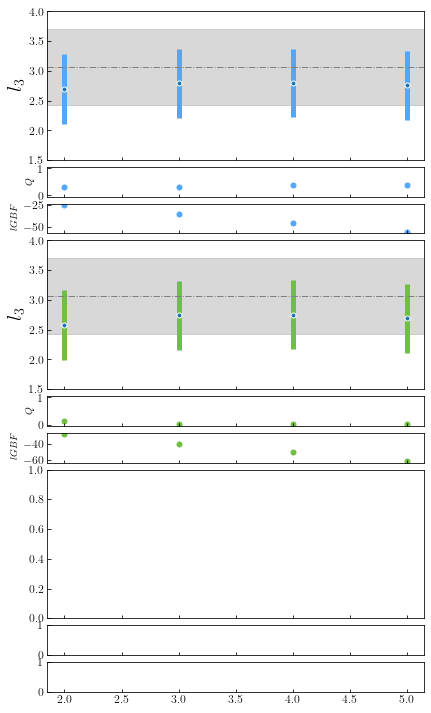

In [ ]:
plt.rcParams['text.usetex'] = True
colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    #model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi_ma:l_lo:d_lo:x_lo']
    model_info_mpi = item['mpi_ma:l_n2lo:d_n2lo:x_n2lo'] #have to include disc effects
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['l_3^a'] = gv.gvar(0,1000)
prior['c_{mpi,2F}'] = gv.gvar(0,20) - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar(0,20) - l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q
prior['B'] = gv.gvar(3000,1000)
num_ensembles = np.arange(2,6)
l_3 = {}
eps2_a = {}

for a_xx in np.unique([ens.split('m')[0] for ens in  all_ensembles]):

    l_3[a_xx] = {}
    l_3[a_xx]['value'] = [] 
    l_3[a_xx]['q'] = []
    l_3[a_xx]['prior'] = []
    l_3[a_xx]['logGBF'] = []

    eps2_a[a_xx] = {}
    eps2_a[a_xx]['value'] = [] 
    

    for num in num_ensembles:
        ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
        if len(ensembles) >= num:
            ensembles = ensembles[:num]
            data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=ensembles)
            fit_mpi_lo = mpi_fit.fit_routine_mpi(prior=prior, data=data, model_info=model_info_mpi)
            fit_lo = fit_mpi_lo.fit

            l_3[a_xx]['value'].append((fit_lo.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2)))
            l_3[a_xx]['q'].append(fit_lo.Q)
            l_3[a_xx]['prior'].append((fit_lo.prior['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2)))
            l_3[a_xx]['logGBF'].append(fit_lo.logGBF)

            # eps2_a[a_xx]['value'].append(fit_n2lo.p['eps2_a'])

fig, (ax_value_a09, ax_q_a09, ax_log_a09, ax_value_a12, ax_q_a12,ax_log_a12, ax_value_a15, ax_q_a15,ax_log_a15) = plt.subplots(nrows=9, sharex=True, 
gridspec_kw={'height_ratios': [5, 1,1, 5, 1,1, 5, 1,1], 'wspace':0.0, 'hspace':0.1})
fig.set_figheight(fig.get_size_inches()[1] *3)

for a_xx, ax_value, ax_q,ax_log in zip(l_3, [ax_value_a09, ax_value_a12, ax_value_a15], [ax_q_a09, ax_q_a12, ax_q_a15],[ax_log_a09, ax_log_a12, ax_log_a15]):

    ax_value.errorbar(
        x=num_ensembles, 
        y=gv.mean(l_3[a_xx]['value']), 
        xerr=0.0, 
        yerr=gv.sdev(l_3[a_xx]['value']),
        capsize=0.0, mec='white', ms=10.0,
        ecolor=colormap[a_xx], 
        elinewidth=5.0, fmt = '.')

    ax_q.scatter(
        x=num_ensembles, 
        y=l_3[a_xx]['q'], 
        color=colormap[a_xx]
    )

    ax_log.scatter(
        x=num_ensembles, 
        y=l_3[a_xx]['logGBF'], 
        color=colormap[a_xx]
    )

    pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
    ax_value.axhspan(pm(l_3_flag, -1), pm(l_3_flag, +1), alpha=0.3, color='grey', label='PDG/FLAG')
    ax_value.axhline(pm(l_3_flag, 0), ls='-.', color='grey')

    ax_value.set_ylabel('$l_3$')
    ax_q.set_ylabel('$Q$',fontsize=10)
    ax_log.set_ylabel('$lGBF$',fontsize= 10)

    ax_q.set_ylim(-0.05, 1.05)

    # if (y_ax_min is not None) and (y_ax_max is not None):
    ax_value.set_ylim(1.5, 4)
        
ax_log_a15.set_xlabel('No. ensembles')
print(l_3)
#fig.savefig('../tmp/l_3_vs_num_ensembles.png')
plt.show()

In [ ]:
plt.rcParams['text.usetex'] = True
colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    #model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi_ma:l_lo:d_lo:x_lo']
    model_info_mpi = item['mpi_ma:l_n2lo:d_n2lo:x_n2lo'] #have to include disc effects
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['l_3^a'] = gv.gvar(0,1000)
prior['c_{mpi,2F}'] = gv.gvar('0(50)') #gv.gvar('0(20)') - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar('0(50)') #- l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q
prior['B'] = gv.gvar(3000,1000)

num_ensembles = np.arange(2,6)
B = {}
l_3 = {}

for a_xx in np.unique([ens.split('m')[0] for ens in all_ensembles]):

    B[a_xx] = {}
    B[a_xx]['value'] = [] 
    B[a_xx]['q'] = []
    B[a_xx]['prior'] = []
    B[a_xx]['logGBF'] = []

    for num in num_ensembles:
        ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
        if len(ensembles) >= num:
            ensembles = ensembles[:num]
            data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=ensembles)
            #print(data)
            fit_mpi = mpi_fit.fit_routine_mpi(prior=prior, data=data, model_info=model_info_mpi)
            #print(fit_mpi)
            fit = fit_mpi.fit

            B[a_xx]['value'].append(fit.p['B'])
            B[a_xx]['q'].append(fit.Q)
            B[a_xx]['logGBF'].append(fit.logGBF)
            B[a_xx]['prior'].append(fit.prior['B'])

            l_3[a_xx] = {}
            l_3[a_xx]['value'] = (fit.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2))
            l_3[a_xx]['q'] = fit.Q


fig, (ax_value_a09, ax_q_a09, ax_log_a09, ax_value_a12, ax_q_a12, ax_log_a12, ax_value_a15, ax_q_a15,ax_log_a15) = plt.subplots(nrows=9, sharex=True, 
gridspec_kw={'height_ratios': [5, 1,1, 5, 1,1, 5, 1,1], 'wspace':0.0, 'hspace':0.15})
fig.set_figheight(fig.get_size_inches()[1] *3)

for a_xx, ax_value, ax_q,ax_log in zip(B, [ax_value_a09, ax_value_a12, ax_value_a15], [ax_q_a09, ax_q_a12, ax_q_a15],[ax_log_a09, ax_log_a12, ax_log_a15]):

    ax_value.errorbar(
        x=num_ensembles, 
        y=gv.mean(B[a_xx]['value']), 
        xerr=0.0, 
        yerr=gv.sdev(B[a_xx]['value']),
        capsize=0.0, mec='white', ms=10.0,
        ecolor=colormap[a_xx], 
        elinewidth=5.0, fmt = '.')

    ax_q.scatter(
        x=num_ensembles, 
        y=B[a_xx]['q'], 
        color=colormap[a_xx]
    )
    ax_log.scatter(
        x=num_ensembles, 
        y=B[a_xx]['logGBF'], 
        color=colormap[a_xx]
    )

    # pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
    # ax_value.axhspan(pm(l_3_flag, -1), pm(l_3_flag, +1), alpha=0.3, color='grey', label='PDG/FLAG')
    # ax_value.axhline(pm(l_3_flag, 0), ls='-.', color='grey')

    ax_value.set_ylabel(r'$B \equiv \frac{\Sigma}{F^2}$')
    ax_q.set_ylabel('$Q$',fontsize=10)
    ax_log.set_ylabel('$lGBF$',fontsize=10)
    ax_q.set_ylim(-0.05, 1.05)
    ax_log.set_ylim(-75, -20)

    # if (y_ax_min is not None) and (y_ax_max is not None):
    ax_value_a12.set_ylim(2500, 5500)
    ax_value_a15.set_ylim(2500, 5500)
        
ax_log_a15.set_xlabel('No. ensembles')
print(fit, '\n',l_3)
#fig.savefig('../tmp/l_3_vs_num_ensembles.png')
plt.show()

KeyError: 'undefined key: l_3^a'

['a09m135', 'a09m220', 'a09m310', 'a09m350', 'a09m400']
['a12m130', 'a12m220', 'a12m310', 'a12m350', 'a12m400']
['a15m220', 'a15m310', 'a15m350', 'a15m400']


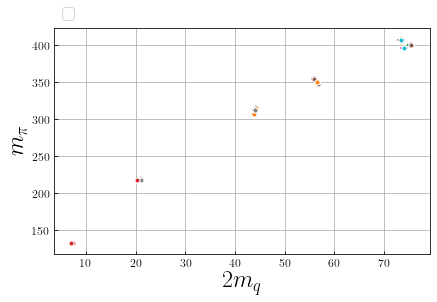

In [ ]:
xparam = 'm_q'
yparam = 'm_pi'

colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}

x = {}
y = {}
for a_xx in np.unique([ens.split('m')[0] for ens in all_ensembles]):
    ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
    print(ensembles)

for i in range(len(all_ensembles)):
    for j, param in enumerate([xparam, yparam]):
        if param =='m_q':
            value = 2*data['m_q'][i]
            label = '$2m_q$'
        if param =='m_pi':
            value = data['m_pi'][i] 
            label = '$m_\pi$'
        if param == 'm_pi_sq':
            value = data['m_pi']**2[i] 
            label = '$m_\pi^2$'

        
        if j == 0:
            x[i] = value
            xlabel = label
        elif j == 1:
            y[i] = value
            ylabel = label

for i in range(len(all_ensembles)):
    C = gv.evalcov([x[i], y[i]])
    eVe, eVa = np.linalg.eig(C)
    for e, v in zip(eVe, eVa.T):
        plt.plot([gv.mean(x[i])-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(x[i])],
                [gv.mean(y[i])-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(y[i])],
                    alpha=1.0, lw=2)
        plt.plot(gv.mean(x[i]), gv.mean(y[i]), 
                    marker='o', mec='w', zorder=3)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
    ncol=len(by_label), bbox_to_anchor=(0,1), loc='lower left')
plt.grid()
plt.xlabel(xlabel, fontsize = 24)
plt.ylabel(ylabel, fontsize = 24)
#plt.axvline(gv.mean(phys_point_data['eps_pi']), ls='--', label='phys. point')

fig = plt.gcf()
plt.show()
plt.close()


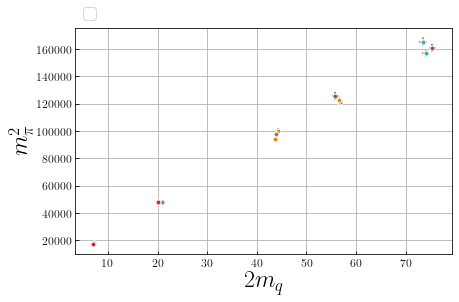

In [ ]:
xparam = 'm_q'
yparam = 'm_pi_sq'

colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}

x = {}
y = {}

for i in range(len(all_ensembles)):
    for j, param in enumerate([xparam, yparam]):
        if param =='m_q':
            value = 2*data['m_q'][i]
            label = '$2m_q$'
        if param =='m_pi':
            value = data['mpi'][i] 
            label = '$m_\pi$'
        if param == 'm_pi_sq':
            value = data['m_pi_sq'][i] 
            label = '$m_\pi^2$'

        
        if j == 0:
            x[i] = value
            xlabel = label
        elif j == 1:
            y[i] = value
            ylabel = label

for i in range(len(all_ensembles)):
    C = gv.evalcov([x[i], y[i]])
    eVe, eVa = np.linalg.eig(C)
    for e, v in zip(eVe, eVa.T):
        plt.plot([gv.mean(x[i])-1*np.sqrt(e)*v[0], 1*np.sqrt(e)*v[0] + gv.mean(x[i])],
                [gv.mean(y[i])-1*np.sqrt(e)*v[1], 1*np.sqrt(e)*v[1] + gv.mean(y[i])],
                    alpha=1.0, lw=2)
        plt.plot(gv.mean(x[i]), gv.mean(y[i]), 
                    marker='o', mec='w', zorder=3)


handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),
    ncol=len(by_label), bbox_to_anchor=(0,1), loc='lower left')
plt.grid()
plt.xlabel(xlabel, fontsize = 24)
plt.ylabel(ylabel, fontsize = 24)
#plt.axvline(gv.mean(phys_point_data['eps_pi']), ls='--', label='phys. point')

fig = plt.gcf()
plt.show()
plt.close()


In [ ]:
x = (273**3)/ 92**2 #* (3.5) * 2 
x 

2403.8772448015125

In [ ]:
from IPython.display import display, clear_output
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo']
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['c_{mpi,2F}'] = gv.gvar(0,20) - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar(0,20) - l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q defined in FLAG  
prior['B'] = gv.gvar(3000,800)
prior['B_a09'] = gv.gvar(3000,700)
prior['B_a12'] = gv.gvar(4000,700)
prior['B_a15'] = gv.gvar(5000,700)
l_3 = {}
B = {}
m_q = {}
for a_xx in np.unique([ens.split('m')[0] for ens in all_ensembles]):
    ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
    #print(ensembles)
    if len(ensembles) >= 2:
        ensembles = ensembles[:4]
    data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=ensembles)
    fit_mpi = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
    fit = fit_mpi.fit
    extrap_mpi = mpi_fit.Mpi(datatag='mpi',model_info=model_info_mpi)
    extrap = extrap_mpi.fitfcn(p=fit.p) 
    display(print(fit,np.sqrt(extrap)))
    l_3[a_xx] = {}
    l_3[a_xx]['l_3'] = (fit.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2))
    l_3[a_xx]['q'] = fit.Q
    # m_q[a_xx] = {}
    # m_q[a_xx]['m_q'] = (fit.p['m_q'])
    #l_3[a_xx]['q'] = fit.Q
    print(l_3)

AttributeError: module 'mpi_fit' has no attribute 'fit_routine'

{'a09': {'value': [3.35(61), 3.37(56), 3.34(54), 3.27(53)], 'q': [0.28717314217273987, 0.4745410600840879, 0.6346012945187183, 0.702022230484589], 'prior': [3.07(64), 3.07(64), 3.07(64), 3.07(64)]}, 'a12': {'value': [3.77(59), 3.86(54), 3.76(53), 3.60(52)], 'q': [0.014639828786434158, 0.03578954039835885, 0.055737574506510776, 0.048473524012796594], 'prior': [3.07(64), 3.07(64), 3.07(64), 3.07(64)]}, 'a15': {'value': [4.11(58), 4.16(52), 4.09(52), 3.96(52)], 'q': [0.0005445023476647241, 0.001767955766962858, 0.0036516654951151807, 0.002931063237839996], 'prior': [3.07(64), 3.07(64), 3.07(64), 3.07(64)]}}


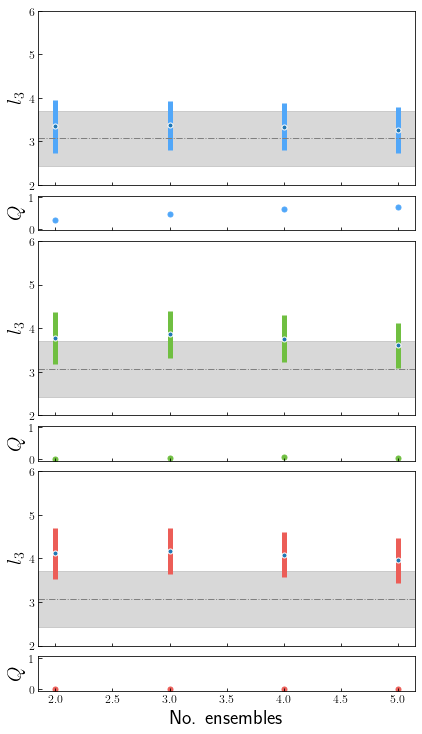

In [ ]:
colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo']
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)
#prior['M_sq'] = gv.gvar(140, 20) 

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['c_{mpi,2F}'] = gv.gvar(0,20) - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar(0,20) - l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q
prior['B'] = gv.gvar(3000,1000)

num_ensembles = np.arange(2,6)
l_3 = {}
eps2_a = {}

for a_xx in np.unique([ens.split('m')[0] for ens in  all_ensembles]):
    #print(all_ensembles)

    l_3[a_xx] = {}
    l_3[a_xx]['value'] = [] 
    l_3[a_xx]['q'] = []
    l_3[a_xx]['prior'] = []

    eps2_a[a_xx] = {}
    eps2_a[a_xx]['value'] = [] 
    

    for num in num_ensembles:
        ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
        #print(ensembles)
        if len(ensembles) >= num:
            ensembles = ensembles[:num]
            data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=ensembles)
            fit_mpi = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
            fit = fit_mpi.fit

            l_3[a_xx]['value'].append((fit.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2)))
            l_3[a_xx]['q'].append(fit.Q)
            l_3[a_xx]['prior'].append((fit.prior['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2)))

            eps2_a[a_xx]['value'].append(fit.p['eps2_a'])

fig, (ax_value_a09, ax_q_a09, ax_value_a12, ax_q_a12, ax_value_a15, ax_q_a15) = plt.subplots(nrows=6, sharex=True, gridspec_kw={'height_ratios': [5, 1, 5, 1, 5, 1], 'wspace':0.0, 'hspace':0.1})
fig.set_figheight(fig.get_size_inches()[1] *3)

for a_xx, ax_value, ax_q in zip(l_3, [ax_value_a09, ax_value_a12, ax_value_a15], [ax_q_a09, ax_q_a12, ax_q_a15]):

    ax_value.errorbar(
        x=num_ensembles, 
        y=gv.mean(l_3[a_xx]['value']), 
        xerr=0.0, 
        yerr=gv.sdev(l_3[a_xx]['value']),
        capsize=0.0, mec='white', ms=10.0,
        ecolor=colormap[a_xx], 
        elinewidth=5.0, fmt = '.')

    ax_q.scatter(
        x=num_ensembles, 
        y=l_3[a_xx]['q'], 
        color=colormap[a_xx]
    )

    pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
    ax_value.axhspan(pm(l_3_flag, -1), pm(l_3_flag, +1), alpha=0.3, color='grey', label='PDG/FLAG')
    ax_value.axhline(pm(l_3_flag, 0), ls='-.', color='grey')

    ax_value.set_ylabel('$l_3$')
    ax_q.set_ylabel('$Q$')
    ax_q.set_ylim(-0.05, 1.05)

    # if (y_ax_min is not None) and (y_ax_max is not None):
    ax_value.set_ylim(2, 6)
        
ax_q_a15.set_xlabel('No. ensembles')
print(l_3)
#fig.savefig('../tmp/l_3_vs_num_ensembles.png')
plt.show()

{'a09': {'value': [3063(670), 3106(567), 3048(518), 2924(478)], 'q': [0.28717314217273987, 0.4745410600840879, 0.6346012945187183, 0.702022230484589], 'prior': [3000(1000), 3000(1000), 3000(1000), 3000(1000)]}, 'a12': {'value': [4319(829), 4501(662), 4323(625), 4141(614)], 'q': [0.014639828786434158, 0.03578954039835885, 0.055737574506510776, 0.048473524012796594], 'prior': [3000(1000), 3000(1000), 3000(1000), 3000(1000)]}, 'a15': {'value': [4901(854), 4991(689), 4841(654), 4607(631)], 'q': [0.0005445023476647241, 0.001767955766962858, 0.0036516654951151807, 0.002931063237839996], 'prior': [3000(1000), 3000(1000), 3000(1000), 3000(1000)]}}


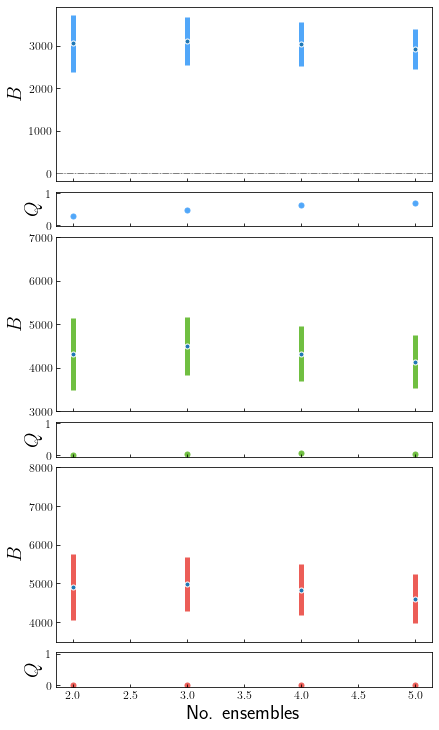

In [ ]:
colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo']
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['c_{mpi,2F}'] = gv.gvar(0,20) - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar(0,20) - l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q
prior['B'] = gv.gvar(3000,1000)
prior['B_a09'] = gv.gvar(3000,1000)
prior['B_a12'] = gv.gvar(5000,1000)
prior['B_a15'] = gv.gvar(7000,1000)


num_ensembles = np.arange(2,6)
B = {}

for a_xx in np.unique([ens.split('m')[0] for ens in  all_ensembles]):

    B[a_xx] = {}
    B[a_xx]['value'] = [] 
    B[a_xx]['q'] = []
    B[a_xx]['prior'] = []

    for num in num_ensembles:
        ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
        if len(ensembles) >= num:
            ensembles = ensembles[:num]
            data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=ensembles)
            fit_mpi = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
            fit = fit_mpi.fit

            B[a_xx]['value'].append(fit.p['B'])
            B[a_xx]['q'].append(fit.Q)
            B[a_xx]['prior'].append(fit.prior['B'])

fig, (ax_value_a09, ax_q_a09, ax_value_a12, ax_q_a12, ax_value_a15, ax_q_a15) = plt.subplots(nrows=6, sharex=True, gridspec_kw={'height_ratios': [5, 1, 5, 1, 5, 1], 'wspace':0.0, 'hspace':0.1})
fig.set_figheight(fig.get_size_inches()[1] *3)

for a_xx, ax_value, ax_q in zip(B, [ax_value_a09, ax_value_a12, ax_value_a15], [ax_q_a09, ax_q_a12, ax_q_a15]):

    ax_value.errorbar(
        x=num_ensembles, 
        y=gv.mean(B[a_xx]['value']), 
        xerr=0.0, 
        yerr=gv.sdev(B[a_xx]['value']),
        capsize=0.0, mec='white', ms=10.0,
        ecolor=colormap[a_xx], 
        elinewidth=5.0, fmt = '.')

    ax_q.scatter(
        x=num_ensembles, 
        y=B[a_xx]['q'], 
        color=colormap[a_xx]
    )

    pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
    ax_value.axhspan(pm(l_3_flag, -1), pm(l_3_flag, +1), alpha=0.3, color='grey', label='PDG/FLAG')
    ax_value.axhline(pm(l_3_flag, 0), ls='-.', color='grey')

    ax_value.set_ylabel('$B$')
    ax_q.set_ylabel('$Q$')
    ax_q.set_ylim(-0.05, 1.05)

    # if (y_ax_min is not None) and (y_ax_max is not None):
    ax_value_a12.set_ylim(3000, 7000)
    ax_value_a15.set_ylim(3500, 8000)
        
ax_q_a15.set_xlabel('No. ensembles')
print(B)
#fig.savefig('../tmp/l_3_vs_num_ensembles.png')
plt.show()

In [ ]:
colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo']
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)
#prior['M_sq'] = gv.gvar(140, 20) 

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['c_{mpi,2F}'] = gv.gvar(0,50) #- (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar(0,50) #- l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q
prior['B'] = gv.gvar(3000,1000)

num_ensembles = np.arange(2,6)
l_3 = {}
eps2_a = {}

for a_xx in np.unique([ens.split('m')[0] for ens in  all_ensembles]):

    l_3[a_xx] = {}
    l_3[a_xx]['value'] = [] 
    l_3[a_xx]['q'] = []
    l_3[a_xx]['prior'] = []
    l_3[a_xx]['logGBF'] = []

    eps2_a[a_xx] = {}
    eps2_a[a_xx]['value'] = [] 
    

    for num in num_ensembles:
        ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
        if len(ensembles) >= num:
            ensembles = ensembles[:num]
            data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=all_ensembles)
            fit_mpi_n2lo = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
            fit_n2lo = fit_mpi_n2lo.fit

            l_3[a_xx]['value'].append((fit_n2lo.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2)))
            l_3[a_xx]['q'].append(fit_n2lo.Q)
            l_3[a_xx]['prior'].append((fit_n2lo.prior['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2)))
            l_3[a_xx]['logGBF'].append(fit_n2lo.logGBF)

            eps2_a[a_xx]['value'].append(fit_n2lo.p['eps2_a'])

fig, (ax_value_a09, ax_q_a09, ax_log_a09, ax_value_a12, ax_q_a12,ax_log_a12, ax_value_a15, ax_q_a15,ax_log_a15) = plt.subplots(nrows=9, sharex=True, 
gridspec_kw={'height_ratios': [5, 1,1, 5, 1,1, 5, 1,1], 'wspace':0.0, 'hspace':0.1})
fig.set_figheight(fig.get_size_inches()[1] *3)

for a_xx, ax_value, ax_q,ax_log in zip(l_3, [ax_value_a09, ax_value_a12, ax_value_a15], [ax_q_a09, ax_q_a12, ax_q_a15],[ax_log_a09, ax_log_a12, ax_log_a15]):

    ax_value.errorbar(
        x=num_ensembles, 
        y=gv.mean(l_3[a_xx]['value']), 
        xerr=0.0, 
        yerr=gv.sdev(l_3[a_xx]['value']),
        capsize=0.0, mec='white', ms=10.0,
        ecolor=colormap[a_xx], 
        elinewidth=5.0, fmt = '.')

    ax_q.scatter(
        x=num_ensembles, 
        y=l_3[a_xx]['q'], 
        color=colormap[a_xx]
    )

    ax_log.scatter(
        x=num_ensembles, 
        y=l_3[a_xx]['logGBF'], 
        color=colormap[a_xx]
    )

    pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
    ax_value.axhspan(pm(l_3_flag, -1), pm(l_3_flag, +1), alpha=0.3, color='grey', label='PDG/FLAG')
    ax_value.axhline(pm(l_3_flag, 0), ls='-.', color='grey')

    ax_value.set_ylabel('$l_3$')
    ax_q.set_ylabel('$Q$',fontsize=10)
    ax_log.set_ylabel('$lGBF$',fontsize= 10)

    ax_q.set_ylim(-0.05, 1.05)

    # if (y_ax_min is not None) and (y_ax_max is not None):
    ax_value.set_ylim(1.5, 4)
        
ax_log_a15.set_xlabel('No. ensembles')
print(l_3)
#fig.savefig('../tmp/l_3_vs_num_ensembles.png')
plt.show()

AttributeError: module 'mpi_fit' has no attribute 'fit_routine'

In [ ]:
print(fit_n2lo,l_3)

Least Square Fit:
  chi2/dof [dof] = 4.1 [15]    Q = 1.5e-07    logGBF = -164.04

Parameters:
              B       2708 (78)      [   3000 (1000) ]  
            l_3       0.42 (14)      [     0.31 (16) ]  
     c_{mpi,2F}         40 (13)      [      -15 (20) ]  **
      d_{mpi,a}      -0.98 (40)      [     0.0 (4.0) ]  
     d_{mpi,aa}       3.7 (1.4)      [     0.0 (4.0) ]  
     d_{mpi,al}      -2.7 (3.9)      [     0.0 (4.0) ]  
     c_{mpi,1F}      28.5 (7.1)      [      -28 (24) ]  **
       eps_pi 0    0.11619 (33)      [  0.11619 (33) ]  
              1    0.18199 (37)      [  0.18197 (37) ]  
              2    0.24618 (44)      [  0.24619 (44) ]  
              3    0.26947 (58)      [  0.26949 (58) ]  
              4    0.29816 (54)      [  0.29819 (54) ]  
              5    0.11359 (33)      [  0.11360 (33) ]  
              6    0.18222 (44)      [  0.18220 (44) ]  
              7    0.24489 (51)      [  0.24486 (51) ]  
              8    0.27064 (69)      [  0.27063

{'a09': {'value': [2887(653), 2789(641), 2789(643), 2891(669)], 'q': [0.25076914427127506, 0.25397773986138855, 0.3195491125773449, 0.294678015327626], 'prior': [3000(1000), 3000(1000), 3000(1000), 3000(1000)], 'logGBF': [-20.531572248467032, -30.9744479652375, -40.523216427912104, -50.801940722070334]}, 'a12': {'value': [3456(875), 3288(889), 3571(908), 4212(887)], 'q': [0.12863705517431615, 0.03297307753303304, 0.01542642239467346, 0.010755641866752168], 'prior': [3000(1000), 3000(1000), 3000(1000), 3000(1000)], 'logGBF': [-21.851765375030002, -33.78041159271059, -44.86233354322793, -56.06978443385615]}, 'a15': {'value': [3711(914), 3476(945), 3751(952), 4452(915)], 'q': [0.07450280950593298, 0.0019783902745411615, 0.001169732815888949, 0.0008864188608247537], 'prior': [3000(1000), 3000(1000), 3000(1000), 3000(1000)], 'logGBF': [-22.88098891309832, -37.35153795157255, -48.26225916952532, -59.58214129109135]}}


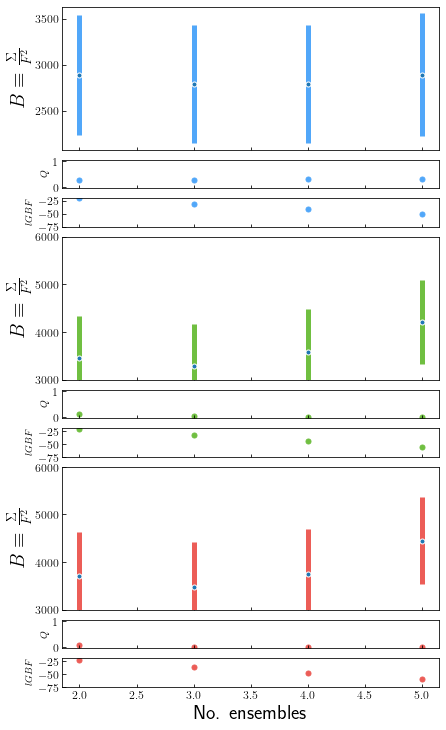

In [ ]:
plt.rcParams['text.usetex'] = True
colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    #model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo'] #have to include disc effects
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['c_{mpi,2F}'] = gv.gvar(0,20) - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar(0,20) - l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q
prior['B'] = gv.gvar(3000,1000)

num_ensembles = np.arange(2,6)
B = {}

for a_xx in np.unique([ens.split('m')[0] for ens in all_ensembles]):

    B[a_xx] = {}
    B[a_xx]['value'] = [] 
    B[a_xx]['q'] = []
    B[a_xx]['prior'] = []
    B[a_xx]['logGBF'] = []

    for num in num_ensembles:
        ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
        if len(ensembles) >= num:
            ensembles = ensembles[:num]
            data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=ensembles)
            fit_mpi = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
            fit = fit_mpi.fit

            B[a_xx]['value'].append(fit.p['B'])
            B[a_xx]['q'].append(fit.Q)
            B[a_xx]['logGBF'].append(fit.logGBF)
            B[a_xx]['prior'].append(fit.prior['B'])

fig, (ax_value_a09, ax_q_a09, ax_log_a09, ax_value_a12, ax_q_a12, ax_log_a12, ax_value_a15, ax_q_a15,ax_log_a15) = plt.subplots(nrows=9, sharex=True, 
gridspec_kw={'height_ratios': [5, 1,1, 5, 1,1, 5, 1,1], 'wspace':0.0, 'hspace':0.15})
fig.set_figheight(fig.get_size_inches()[1] *3)

for a_xx, ax_value, ax_q,ax_log in zip(B, [ax_value_a09, ax_value_a12, ax_value_a15], [ax_q_a09, ax_q_a12, ax_q_a15],[ax_log_a09, ax_log_a12, ax_log_a15]):

    ax_value.errorbar(
        x=num_ensembles, 
        y=gv.mean(B[a_xx]['value']), 
        xerr=0.0, 
        yerr=gv.sdev(B[a_xx]['value']),
        capsize=0.0, mec='white', ms=10.0,
        ecolor=colormap[a_xx], 
        elinewidth=5.0, fmt = '.')

    ax_q.scatter(
        x=num_ensembles, 
        y=B[a_xx]['q'], 
        color=colormap[a_xx]
    )
    ax_log.scatter(
        x=num_ensembles, 
        y=B[a_xx]['logGBF'], 
        color=colormap[a_xx]
    )

    # pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
    # ax_value.axhspan(pm(l_3_flag, -1), pm(l_3_flag, +1), alpha=0.3, color='grey', label='PDG/FLAG')
    # ax_value.axhline(pm(l_3_flag, 0), ls='-.', color='grey')

    ax_value.set_ylabel(r'$B \equiv \frac{\Sigma}{F^2}$')
    ax_q.set_ylabel('$Q$',fontsize=10)
    ax_log.set_ylabel('$lGBF$',fontsize=10)
    ax_q.set_ylim(-0.05, 1.05)
    ax_log.set_ylim(-75, -20)

    # if (y_ax_min is not None) and (y_ax_max is not None):
    ax_value_a12.set_ylim(3000, 6000)
    ax_value_a15.set_ylim(3000, 6000)
        
ax_log_a15.set_xlabel('No. ensembles')
print(B)
#fig.savefig('../tmp/l_3_vs_num_ensembles.png')
plt.show()

In [ ]:
print(fit)

Least Square Fit:
  chi2/dof [dof] = 4.2 [5]    Q = 0.00089    logGBF = -59.582

Parameters:
              B     4452 (915)      [  3000 (1000) ]  *
            l_3      0.41 (14)      [    0.31 (16) ]  
     c_{mpi,2F}        27 (14)      [     -15 (20) ]  **
      d_{mpi,a}     -1.97 (97)      [    0.0 (4.0) ]  
     d_{mpi,aa}     -0.3 (3.9)      [    0.0 (4.0) ]  
     d_{mpi,al}      0.4 (4.0)      [    0.0 (4.0) ]  
     c_{mpi,1F}     18.7 (8.2)      [     -28 (24) ]  *
       eps_pi 0   0.11492 (20)      [ 0.11492 (20) ]  
              1   0.18085 (31)      [ 0.18084 (31) ]  
              2   0.24957 (36)      [ 0.24957 (36) ]  
              3   0.27412 (52)      [ 0.27412 (52) ]  
              4   0.30374 (54)      [ 0.30374 (54) ]  
          m_q 0     3.486 (22)      [   3.462 (23) ]  *
              1    10.027 (63)      [  10.087 (67) ]  
              2     21.92 (14)      [   21.97 (15) ]  
              3     28.24 (18)      [   28.24 (19) ]  
              4     37

In [ ]:
from IPython.display import display, clear_output
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    #model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo']
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['c_{mpi,2F}'] = gv.gvar(0,20) - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar(0,20) - l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q defined in FLAG  
prior['B'] = gv.gvar(3000,800)
prior['Ba09'] = gv.gvar(3000,700)
prior['Ba12'] = gv.gvar(4000,700)
prior['Ba15'] = gv.gvar(5000,700)
l_3 = {}
B = {}
m_q = {}
for a_xx in np.unique([ens.split('m')[0] for ens in all_ensembles]):
    ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
    #print(ensembles)
    if len(ensembles) >= 2:
        ensembles = ensembles[:2]
    data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=ensembles)
    fit_mpi = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
    fit = fit_mpi.fit
    extrap_mpi = mpi_fit.Mpi(datatag='mpi',model_info=model_info_mpi)
    extrap = extrap_mpi.fitfcn(p=fit.p) 
    display(print(fit,np.sqrt(extrap)))
    l_3[a_xx] = {}
    l_3[a_xx]['value'] = (fit.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2))
    l_3[a_xx]['q'] = fit.Q

    B[a_xx] = {}
    B[a_xx]['value'] = (fit.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2))
    B[a_xx]['q'] = fit.Q
    # m_q[a_xx] = {}
    # m_q[a_xx]['m_q'] = (fit.p['m_q'])
    #l_3[a_xx]['q'] = fit.Q
    print(l_3)

Least Square Fit:
  chi2/dof [dof] = 1.2 [2]    Q = 0.29    logGBF = -19.256

Parameters:
              B      3048 (596)      [    3000 (800) ]  
            l_3       0.24 (15)      [     0.31 (16) ]  
      d_{mpi,a}      -2.9 (2.3)      [     0.0 (4.0) ]  
       eps_pi 0    0.11619 (33)      [  0.11619 (33) ]  
              1    0.18198 (37)      [  0.18197 (37) ]  
          m_q 0      3.660 (28)      [    3.648 (29) ]  
              1     10.489 (81)      [   10.524 (84) ]  
       eps2_a 0   0.065324 (70)      [ 0.065325 (70) ]  
              1   0.066507 (83)      [ 0.066506 (83) ]  
         m_pi 0     133.5 (1.1)      [   133.5 (1.1) ]  
              1     219.8 (1.8)      [   219.8 (1.8) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 13/0.0)
 [132.52(89) 221.3(1.5)]


None

{'a09': {'value': 3.35(61), 'q': 0.28693204507943076}}
Least Square Fit:
  chi2/dof [dof] = 4.6 [2]    Q = 0.01    logGBF = -23.235

Parameters:
              B      3951 (696)      [    3000 (800) ]  *
            l_3       0.13 (15)      [     0.31 (16) ]  *
      d_{mpi,a}      -2.86 (87)      [     0.0 (4.0) ]  
       eps_pi 0    0.11359 (33)      [  0.11360 (33) ]  
              1    0.18221 (44)      [  0.18220 (44) ]  
          m_q 0      3.477 (24)      [    3.458 (25) ]  
              1     10.418 (74)      [   10.475 (76) ]  
       eps2_a 0   0.123781 (95)      [ 0.123786 (95) ]  
              1    0.12584 (19)      [  0.12582 (19) ]  
         m_pi 0     132.28 (99)      [   132.29 (99) ]  
              1     218.5 (1.6)      [   218.5 (1.6) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 16/0.0)
 [130.65(83) 220.8(1.4)]


None

{'a09': {'value': 3.35(61), 'q': 0.28693204507943076}, 'a12': {'value': 3.78(59), 'q': 0.010288904938033801}}
Least Square Fit:
  chi2/dof [dof] = 8.2 [2]    Q = 0.00026    logGBF = -27.379

Parameters:
              B     4370 (714)      [   3000 (800) ]  *
            l_3      0.05 (15)      [    0.31 (16) ]  *
      d_{mpi,a}     -1.96 (49)      [    0.0 (4.0) ]  
       eps_pi 0   0.11492 (20)      [ 0.11492 (20) ]  
              1   0.18085 (31)      [ 0.18084 (31) ]  
          m_q 0     3.486 (22)      [   3.462 (23) ]  *
              1    10.021 (65)      [  10.087 (67) ]  
       eps2_a 0   0.19514 (12)      [ 0.19514 (12) ]  
              1   0.19741 (28)      [ 0.19737 (28) ]  
         m_pi 0    136.12 (92)      [  136.12 (92) ]  
              1    218.6 (1.5)      [  218.6 (1.5) ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 16/0.0)
 [134.11(78) 221.5(1.3)]


None

{'a09': {'value': 3.35(61), 'q': 0.28693204507943076}, 'a12': {'value': 3.78(59), 'q': 0.010288904938033801}, 'a15': {'value': 4.12(59), 'q': 0.0002616678068439312}}


In [ ]:
from IPython.display import display, clear_output
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    model_info_mpi = item['mpi_ma:l_n2lo:d_n2lo:x_n2lo']
    #model_info_mpi = item['mpi:l_n2lo:d_n2lo:x_n2lo']
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['l_3^a'] = gv.gvar(0,1000) # this lec does not exist if studying a single lattice spacing #
prior['c_{mpi,2F}'] = gv.gvar(0,20) - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar(0,20) - l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q defined in FLAG  
prior['B'] = gv.gvar(3000,800)
l_3 = {}
B = {}
m_q = {}
for a_xx in np.unique([ens.split('m')[0] for ens in all_ensembles]):
    ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
    #print(ensembles)
    if len(ensembles) >= 2:
        ensembles = ensembles[:2]
    data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=ensembles)
    fit_mpi = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
    fit = fit_mpi.fit
    extrap_mpi = mpi_fit.Mpi(datatag='mpi',model_info=model_info_mpi)
    extrap = extrap_mpi.fitfcn(p=fit.p) 
    display(print(fit,np.sqrt(extrap)))
    l_3[a_xx] = {}
    l_3[a_xx]['value'] = (fit.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2))
    l_3[a_xx]['q'] = fit.Q

    B[a_xx] = {}
    B[a_xx]['value'] = (fit.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2))
    B[a_xx]['q'] = fit.Q
    # m_q[a_xx] = {}
    # m_q[a_xx]['m_q'] = (fit.p['m_q'])
    #l_3[a_xx]['q'] = fit.Q
    print(l_3)

In [ ]:
plt.rcParams['text.usetex'] = True
colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}
f = open('models.yaml', 'r')
models = yaml.load(f,Loader=yaml.FullLoader)
model_info = {}
for item in models.values():
    #model_info_mpi = item['mpi:l_lo:d_lo:x_lo']
    model_info_mpi = item['mpi_ma:l_n2lo:d_n2lo:x_n2lo'] #have to include disc effects
prior = {}
l_3_flag = gv.gvar(3.07,.64)
l_4_flag = gv.gvar(4.02,.45)

#quark mass dependence of l_3 given through:
prior['l_3'] = (l_3_flag + np.log(phys_point_data['eps_pi']**2)) / (-4)
prior['l_4'] = (l_4_flag + np.log(phys_point_data['eps_pi']**2))
prior['l_3^a'] = gv.gvar(0,1000)
prior['c_{mpi,2F}'] = gv.gvar(0,20) - (6*l_3_flag) + l_4_flag - 1/4
prior['c_{mpi,1F}'] = gv.gvar(0,20) - l_3_flag*(1+4*l_3_flag - l_4_flag)
prior['d_{mpi,a}']  = gv.gvar(0,4)
prior['d_{mpi,ll}'] = gv.gvar(0,4)
prior['d_{mpi,al}'] = gv.gvar(0,4)
prior['d_{mpi,aa}'] = gv.gvar(0,4)
# quark condensate := mpi^2 / 2m_q
prior['B'] = gv.gvar(3000,1000)

num_ensembles = np.arange(2,6)
B = {}
l_3 = {}

for a_xx in np.unique([ens.split('m')[0] for ens in all_ensembles]):

    B[a_xx] = {}
    B[a_xx]['value'] = [] 
    B[a_xx]['q'] = []
    B[a_xx]['prior'] = []
    B[a_xx]['logGBF'] = []

    for num in num_ensembles:
        ensembles = [ens for ens in all_ensembles if ens.startswith(a_xx)]
        if len(ensembles) >= num:
            ensembles = ensembles[:num]
            data= input_output.get_data(scheme='w0_org',units='phys',include_phys=False,ensembles=ensembles)
            print(data)
            fit_mpi = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
            fit = fit_mpi.fit

            B[a_xx]['value'].append(fit.p['B'])
            B[a_xx]['q'].append(fit.Q)
            B[a_xx]['logGBF'].append(fit.logGBF)
            B[a_xx]['prior'].append(fit.prior['B'])

            l_3[a_xx] = {}
            l_3[a_xx]['value'] = (fit.p['l_3']*(-4) - np.log(phys_point_data['eps_pi']**2))
            l_3[a_xx]['q'] = fit.Q


fig, (ax_value_a09, ax_q_a09, ax_log_a09, ax_value_a12, ax_q_a12, ax_log_a12, ax_value_a15, ax_q_a15,ax_log_a15) = plt.subplots(nrows=9, sharex=True, 
gridspec_kw={'height_ratios': [5, 1,1, 5, 1,1, 5, 1,1], 'wspace':0.0, 'hspace':0.15})
fig.set_figheight(fig.get_size_inches()[1] *3)

for a_xx, ax_value, ax_q,ax_log in zip(B, [ax_value_a09, ax_value_a12, ax_value_a15], [ax_q_a09, ax_q_a12, ax_q_a15],[ax_log_a09, ax_log_a12, ax_log_a15]):

    ax_value.errorbar(
        x=num_ensembles, 
        y=gv.mean(B[a_xx]['value']), 
        xerr=0.0, 
        yerr=gv.sdev(B[a_xx]['value']),
        capsize=0.0, mec='white', ms=10.0,
        ecolor=colormap[a_xx], 
        elinewidth=5.0, fmt = '.')

    ax_q.scatter(
        x=num_ensembles, 
        y=B[a_xx]['q'], 
        color=colormap[a_xx]
    )
    ax_log.scatter(
        x=num_ensembles, 
        y=B[a_xx]['logGBF'], 
        color=colormap[a_xx]
    )

    # pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
    # ax_value.axhspan(pm(l_3_flag, -1), pm(l_3_flag, +1), alpha=0.3, color='grey', label='PDG/FLAG')
    # ax_value.axhline(pm(l_3_flag, 0), ls='-.', color='grey')

    ax_value.set_ylabel(r'$B \equiv \frac{\Sigma}{F^2}$')
    ax_q.set_ylabel('$Q$',fontsize=10)
    ax_log.set_ylabel('$lGBF$',fontsize=10)
    ax_q.set_ylim(-0.05, 1.05)
    ax_log.set_ylim(-75, -20)

    # if (y_ax_min is not None) and (y_ax_max is not None):
    ax_value_a12.set_ylim(3000, 6000)
    ax_value_a15.set_ylim(3000, 6000)
        
ax_log_a15.set_xlabel('No. ensembles')
print(fit)
#fig.savefig('../tmp/l_3_vs_num_ensembles.png')
plt.show()

{'m_k': array([0.218500(78), 0.228703(91)], dtype=object), 'm_pi': array([133.5(1.1), 219.8(1.8)], dtype=object), 'eps_pi': array([0.11619(33), 0.18197(37)], dtype=object), 'lam_chi': array([0.5116(13), 0.53796(99)], dtype=object), 'm_proton': array([0.4240(32), 0.4353(95)], dtype=object), 'm_delta': array([0.6109(57), 0.587(29)], dtype=object), 'eps_proton': array([0.8287(63), 0.809(17)], dtype=object), 'Fpi': array([262.7(2.2), 410.3(3.4)], dtype=object), 'eps_pi_sea_tilde': array([0.11702(33), 0.18276(37)], dtype=object), 'eps2_a': array([0.065325(70), 0.066506(83)], dtype=object), 'm_q': array([3.648(29), 10.524(84)], dtype=object), 'm_pi_sq': array([17812(290), 48308(783)], dtype=object), 'a2DI': array([[0.0004225221250009785],
       [0.0004225221250009785]], dtype=object)}


TypeError: gammaQ() takes 1 positional argument but 2 were given

ValueError: 'x' and 'y' must have the same size

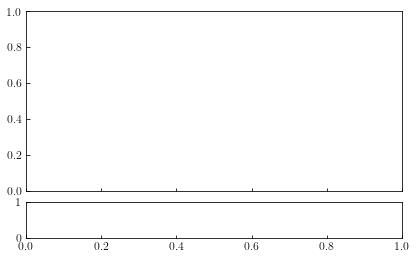

In [ ]:
# get the two lightest ensembles at a given lattice spacing
fig, (ax_value, ax_q) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [5, 1], 'wspace':0.0, 'hspace':0.1})


ax_value.errorbar(
x=fit.p['eps2_a'], 
y=gv.mean([l_3[a_xx]['value'] for a_xx in l_3]), 
xerr=0.0, 
yerr=gv.sdev([l_3[a_xx]['value'] for a_xx in l_3]),
capsize=0.0, mec='white', ms=10.0,
ecolor=[colormap[a_xx] for a_xx in l_3], 
elinewidth=5.0, fmt = '.')

ax_q.scatter(
x=fit.p['eps2_a'], 
y=[l_3[a_xx]['q'] for a_xx in l_3], 
color=[colormap[a_xx] for a_xx in l_3])

ax_value.set_ylabel('$l_3$')
ax_q.set_ylabel('$Q$')
ax_q.set_ylim(-0.05, 1.05)

ax_value.set_xticks(-np.arange(len(l_3))
)
ax_value.set_xticklabels([a_xx for a_xx in l_3])

pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)
ax_value.axhspan(pm(l_3_flag, -1), pm(l_3_flag, +1), alpha=0.3, color='salmon', label='PDG/FLAG')
ax_value.axhline(pm(l_3_flag, 0), ls='-.', color='salmon')

fig.savefig('../tmp/l_4_vs_epsa.png')

plt.show()

## Mpi^2 vs. m_q ##

## Mpi vs m_q ##

## NLO CONTINUUM fit 

In [ ]:

colormap = {
    'a06' : '#6A5ACD',
    'a09' : '#51a7f9',
    'a12' : '#70bf41',
    'a15' : '#ec5d57',
}

results = {}

for a_xx in np.unique([ens.split('m')[0] for ens in  ensembles]):
    ensembles_ = [ens for ens in ensembles if ens.startswith(a_xx)]
    if len(ensembles_) >= 2:
        ensembles_ = ensembles_[:2]
        data, ensembles_ = input_output.get_data(scheme='w0_org',units='phys',include_phys=False)

        #mass_average = xpt.mass.MassAverage(data, data_phys_point, prior, models, ensembles)
        #fit = mass_average.fitter().fit
        results[a_xx] = {}
        results[a_xx]['posterior'] = {key : [] for key in prior}
        results[a_xx]['q'] = []
        results[a_xx]['prior'] = {key : [] for key in prior}
        results[a_xx]['logGBF'] = [] 
        for prior_width in np.linspace(1, 20, 10):
            prior['c_{mpi,2F}'] = gv.gvar(0, prior_width)
            prior['c_{mpi,1F}'] = gv.gvar(0, prior_width)
            prior['l_3'] = gv.gvar(0, prior_width)
            fit_mpi = mpi_fit.fit_routine(prior=prior, data=data, model_info=model_info_mpi)
            fit = fit_mpi.fit

            #for key in prior:
                # if key == 'l_3':
                #     results[a_xx]['posterior']['l_3'].append(fit.p['l_3'] - np.log(phys_point_data['eps_pi']**2))
                #     results[a_xx]['prior']['l_3'].append(fit.prior['l_3'] - np.log(phys_point_data['eps_pi']**2))
                # else:
                #     results[a_xx]['posterior'][key].append(fit.p[key])
                #     results[a_xx]['prior'][key].append(fit.prior[key])

            results[a_xx]['posterior']['l_3'].append(fit.p['l_3'] - np.log(phys_point_data['eps_pi']**2))
            results[a_xx]['prior']['l_3'].append(fit.prior['l_3'] - np.log(phys_point_data['eps_pi']**2))
            results[a_xx]['q'].append(fit.Q)
            results[a_xx]['logGBF'].append(fit.logGBF)
            

fig, (ax_value_a09, ax_q_a09, ax_w_a09, ax_value_a12, ax_q_a12, ax_w_a12, ax_value_a15, ax_q_a15, ax_w_a15) = plt.subplots(nrows=9, sharex=True, gridspec_kw={'height_ratios': [5, 1, 1, 5, 1, 1, 5, 1, 1], 'wspace':0.0, 'hspace':0.1})
fig.set_figheight(fig.get_size_inches()[1] *3)

for a_xx, ax_value, ax_q, ax_w in zip(results, [ax_value_a09, ax_value_a12, ax_value_a15], [ax_q_a09, ax_q_a12, ax_q_a15], [ax_w_a09, ax_w_a12, ax_w_a15]):

    lec = 'l_3'
    pm = lambda g, k : gv.mean(g) + k*gv.sdev(g)

    x = gv.sdev(results[a_xx]['prior']['l_3'])
    ax_value.plot(
        x, 
        pm(results[a_xx]['posterior'][lec], 0),
        color=colormap[a_xx], ls='--'
    )

    ax_value.plot(
        x, 
        pm(results[a_xx]['posterior'][lec], -1),
        x, 
        pm(results[a_xx]['posterior'][lec], 1),
        color=colormap[a_xx]
    )

    ax_value.fill_between(
        x,
        pm(results[a_xx]['posterior'][lec], 1),
        pm(results[a_xx]['posterior'][lec], -1),
        facecolor=colormap[a_xx], alpha=0.7
    )

    #ax_value.axhspan(pm(l_4_flag, -1), pm(l_4_flag, +1), alpha=0.3, color='grey', label='PDG/FLAG')
    #ax_value.axhline(pm(l_4_flag, 0), ls='-.', color='grey')

    ax_q.plot(
        x, 
        results[a_xx]['q'], 
        color=colormap[a_xx]
    )

    ax_w.plot(
        x, 
        np.exp(np.array(results[a_xx]['logGBF'])-results[a_xx]['logGBF'][0]), 
        color=colormap[a_xx]
    )

    ax_value.set_ylabel('$%s$'%(lec))
    ax_q.set_ylabel('$Q$')
    ax_q.set_ylim(-0.05, 1.05)

    ax_w.set_ylabel('BF')

    #if (y_ax_min is not None) and (y_ax_max is not None):
    #    ax_value.set_ylim(y_ax_min, y_ax_max)
        

ax_w_a15.set_xlabel('$\sigma$')

#fig.savefig('../tmp/l_4_vs_prior_width.png')
plt.show()

TypeError: 'NoneType' object is not iterable

In [ ]:
print(results)

{}


In [ ]:
fit_mpi = mpi_fit.fit_routine(prior=new_prior, data=data, model_info=model_info_mpi)
fit_mpi_out = fit_mpi.fit
extrap_mpi = mpi_fit.Mpi(datatag='mpi',model_info=model_info_mpi)
extrap = extrap_mpi.fitfcn(p=fit_mpi_out.p)
#print(fit_fpi_out)
print( '\n','ens:',ensembles,'\n','extrapolation:',extrap, '\n',fit_mpi_out.format(True))

NameError: name 'new_prior' is not defined

## B vs $\epsilon_a^2$

## $\bar{l}_3$ vs $\epsilon_a^2$

## N2LO CONTINUUM fit 

In [ ]:
fit_mpi = mpi_fit.fit_routine(prior=new_prior, data=data, model_info=model_info_mpi)
fit_mpi_out = fit_mpi.fit
extrap_mpi = mpi_fit.Mpi(datatag='mpi',model_info=model_info_mpi)
extrap = extrap_mpi.fitfcn(p=fit_mpi_out.p)
#print(fit_fpi_out)
print( '\n','ens:',ensembles,'\n','extrapolation:',extrap, '\n',fit_mpi_out.format(True))